### Analyze the Spread of Novel CoronaVirus 
#### [Data Source: Johns Hopkins University](https://docs.google.com/spreadsheets/d/1yZv9w9zRKwrGTaR-YzmAqMefw4wMlaXocejdxZaTs6w/htmlview?usp=drive_web&ouid=110279678181267528108&sle=true)

In [1]:
import pandas as pd

#### Load all sheets in the underlying file

In [2]:
file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'

In [3]:
raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

In [4]:
# Merge duplicate columns with different names

main_df = raw_df

main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']

main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Date last updated'])]
main_df

,Confirmed,Country/Region,Deaths,Last Update,Province/State,"Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.",Recovered,Suspected,Unnamed: 6,Unnamed: 7
0,9074.0,Mainland China,294.0,2020-02-01 23:33:00,Hubei,NaN,215.0,NaN,NaN,NaN
1,661.0,Mainland China,0.0,2020-02-02 02:13:00,Zhejiang,NaN,23.0,NaN,NaN,NaN
2,604.0,Mainland China,0.0,2020-02-02 01:23:00,Guangdong,NaN,14.0,NaN,NaN,NaN
3,493.0,Mainland China,2.0,2020-02-02 00:53:00,Henan,NaN,4.0,NaN,NaN,NaN
4,463.0,Mainland China,0.0,2020-02-02 01:53:00,Hunan,NaN,8.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1318,NaN,China,NaN,2020-01-21 00:00:00,Heilongjiang,NaN,NaN,1.0,NaN,NaN
1319,1.0,Japan,NaN,2020-01-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1320,2.0,Thailand,NaN,2020-01-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1321,1.0,South Korea,NaN,2020-01-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']

main_df['day'] = main_df['Last Update'].dt.day
main_df['month'] = main_df['Last Update'].dt.month
main_df = main_df.fillna(0) # will take max value in the next step

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [6]:
clean_df =main_df.groupby(['Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

In [7]:
clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))

In [8]:
clean_df

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period
0,Anhui,1,21,2020-01-21 00:00:00,0.0,3.0,0.0,0.0,2020-01-21
1,Anhui,1,22,2020-01-22 12:00:00,1.0,4.0,0.0,0.0,2020-01-22
2,Anhui,1,23,2020-01-23 12:00:00,9.0,4.0,0.0,0.0,2020-01-23
3,Anhui,1,24,2020-01-24 12:00:00,15.0,4.0,0.0,0.0,2020-01-24
4,Anhui,1,25,2020-01-25 12:00:00,60.0,4.0,0.0,0.0,2020-01-25
...,...,...,...,...,...,...,...,...,...
620,Zhejiang,1,29,2020-01-29 21:00:00,428.0,0.0,4.0,0.0,2020-01-29
621,Zhejiang,1,30,2020-01-30 21:30:00,537.0,0.0,9.0,0.0,2020-01-30
622,Zhejiang,1,31,2020-01-31 19:00:00,538.0,0.0,14.0,0.0,2020-01-31
623,Zhejiang,2,1,2020-02-01 10:53:00,599.0,0.0,21.0,0.0,2020-02-01


#### Some baisc checks

In [9]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')

In [10]:
clean_df['Last Update'].value_counts().sort_index()

2020-01-21 00:00:00    27
2020-01-22 12:00:00    38
2020-01-23 12:00:00    46
2020-01-24 12:00:00    40
2020-01-24 16:00:00     1
2020-01-25 12:00:00    42
2020-01-25 22:00:00     2
2020-01-26 23:00:00    47
2020-01-27 09:00:00     1
2020-01-27 20:30:00    52
2020-01-28 18:00:00     1
2020-01-28 23:00:00    51
2020-01-29 21:00:00    56
2020-01-30 21:30:00    59
2020-01-31 19:00:00    63
2020-02-01 10:00:00    41
2020-02-01 10:33:00     1
2020-02-01 10:43:00     1
2020-02-01 10:53:00     1
2020-02-01 11:03:00     1
2020-02-01 13:33:00     1
2020-02-01 14:03:00     1
2020-02-01 14:23:00     1
2020-02-01 15:23:00     1
2020-02-01 15:43:00     2
2020-02-01 15:53:00     1
2020-02-01 17:43:00     1
2020-02-01 18:12:00     6
2020-02-01 18:53:00     1
2020-02-01 19:43:00     4
2020-02-01 19:53:00     3
2020-02-01 23:33:00     3
2020-02-01 23:43:00     2
2020-02-02 00:23:00     2
2020-02-02 00:43:00     1
2020-02-02 00:53:00     1
2020-02-02 01:03:00     6
2020-02-02 01:13:00     1
2020-02-02 0

In [11]:
clean_df[clean_df['Confirmed'] >= 10]

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period
3,Anhui,1,24,2020-01-24 12:00:00,15.0,4.0,0.0,0.0,2020-01-24
4,Anhui,1,25,2020-01-25 12:00:00,60.0,4.0,0.0,0.0,2020-01-25
5,Anhui,1,26,2020-01-26 23:00:00,70.0,4.0,0.0,0.0,2020-01-26
6,Anhui,1,27,2020-01-27 20:30:00,106.0,0.0,0.0,0.0,2020-01-27
7,Anhui,1,28,2020-01-28 23:00:00,152.0,0.0,0.0,0.0,2020-01-28
...,...,...,...,...,...,...,...,...,...
620,Zhejiang,1,29,2020-01-29 21:00:00,428.0,0.0,4.0,0.0,2020-01-29
621,Zhejiang,1,30,2020-01-30 21:30:00,537.0,0.0,9.0,0.0,2020-01-30
622,Zhejiang,1,31,2020-01-31 19:00:00,538.0,0.0,14.0,0.0,2020-01-31
623,Zhejiang,2,1,2020-02-01 10:53:00,599.0,0.0,21.0,0.0,2020-02-01


#### Some Analysis on spread and recovery

##### Growth rate of confirmed cases

In [12]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

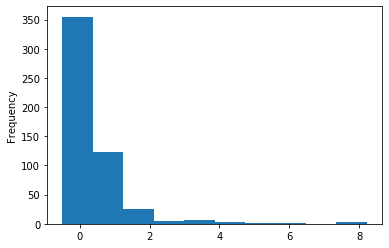

In [13]:
clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

In [14]:
clean_df['growth rate daily'].describe()

count    540.000000
mean            inf
std             NaN
min       -0.500000
25%        0.000000
50%        0.203755
75%        0.547484
max             inf
Name: growth rate daily, dtype: float64

In [15]:
# focus on cases where base is above 10

In [16]:
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 8]
heavy_affect_df.describe()

,month,day,Confirmed,Suspected,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,1.226619,21.971223,230.794964,1.226619,4.841727,4.931655,181.136691,49.658273,0.359759
std,0.419399,11.340126,858.126023,7.079416,19.706239,29.715480,673.172394,193.910364,0.620781
min,1.000000,1.000000,8.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000
25%,1.000000,23.000000,23.000000,0.000000,0.000000,0.000000,16.250000,3.000000,0.105605
50%,1.000000,27.000000,59.000000,0.000000,1.000000,0.000000,43.500000,11.000000,0.226627
75%,1.000000,29.750000,151.750000,0.000000,2.000000,0.000000,121.000000,26.500000,0.416071
max,2.000000,31.000000,9074.000000,72.000000,215.000000,294.000000,7153.000000,1921.000000,8.222222


In [17]:
heavy_affect_df['rank by area'] = heavy_affect_df.groupby('Province/State')['period'].rank()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
growth_df = heavy_affect_df.pivot_table(values = 'growth rate daily', index = 'rank by area', columns='Province/State').reset_index()
growth_df

Province/State,rank by area,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,...,Shanxi,Sichuan,Singapore,South Korea,Taiwan,Thailand,Tianjin,Xinjiang,Yunnan,Zhejiang
0,1.0,0.666667,0.400000,2.000000,0.800000,0.357143,0.529412,0.434783,0.000000,1.375000,...,0.444444,0.875000,0.000,0.090909,0.000000,0.000000,0.625000,0.076923,0.727273,1.700000
1,2.0,3.000000,0.571429,1.777778,0.944444,0.263158,0.230769,0.393939,0.333333,0.157895,...,0.538462,1.933333,0.600,0.250000,0.125000,0.750000,0.076923,0.214286,0.368421,0.592593
2,3.0,0.166667,0.636364,0.466667,0.685714,0.083333,0.656250,0.108696,0.250000,0.500000,...,0.350000,0.568182,0.125,NaN,0.111111,0.000000,0.642857,0.000000,0.692308,1.418605
3,4.0,0.514286,0.416667,0.200000,0.389831,0.115385,0.849057,0.137255,0.933333,0.303030,...,0.296296,0.304348,0.000,NaN,0.000000,0.000000,0.086957,0.058824,0.250000,0.230769
4,5.0,0.433962,0.333333,0.113636,0.231707,0.206897,0.489796,0.344828,0.000000,0.000000,...,0.114286,0.200000,NaN,NaN,NaN,0.357143,0.080000,0.166667,0.381818,0.351562
5,6.0,0.315789,0.176471,0.122449,0.000000,0.142857,0.034247,0.115385,0.310345,0.162791,...,0.205128,0.314815,NaN,NaN,NaN,0.000000,0.185185,NaN,0.092105,0.710983
6,7.0,0.185000,0.137500,0.248485,0.188119,NaN,0.596026,0.011494,NaN,0.160000,...,0.191489,0.246479,NaN,NaN,NaN,NaN,0.000000,NaN,0.120482,0.445946
7,8.0,0.000000,0.219780,0.155340,0.200000,NaN,0.290456,0.136364,NaN,0.068966,...,NaN,0.000000,NaN,NaN,NaN,NaN,0.281250,NaN,NaN,0.254673
8,9.0,0.253165,0.090090,0.100840,0.104167,NaN,0.263666,0.110000,NaN,0.016129,...,NaN,0.169492,NaN,NaN,NaN,NaN,0.097561,NaN,NaN,0.001862
9,10.0,0.144781,0.148760,NaN,NaN,NaN,0.109415,NaN,NaN,NaN,...,NaN,0.115942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113383


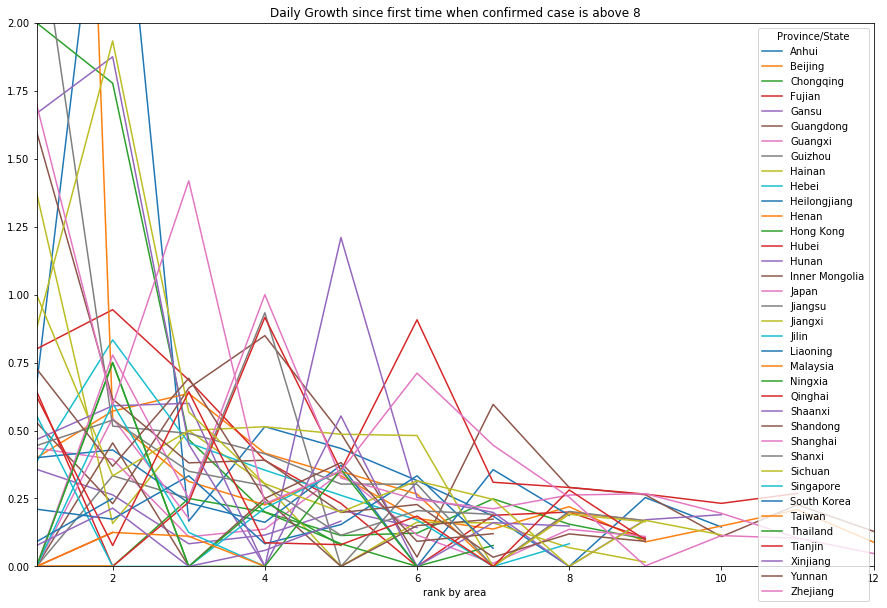

In [19]:
growth_df.set_index('rank by area').plot(figsize =(15, 10), 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

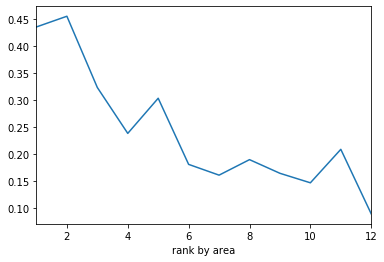

In [49]:
# deceleration? caveat: ommision bias
growth_df.set_index('rank by area').median(axis =1).plot()

In [20]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df

,Province/State,base
0,Anhui,15.0
1,Beijing,14.0
2,Chongqing,27.0
3,Fujian,18.0
4,Gansu,19.0
5,Guangdong,26.0
6,Guangxi,33.0
7,Guizhou,9.0
8,Hainan,19.0
9,Hebei,18.0


In [21]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')
heavy_affect_df

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,rank by area,base
0,Anhui,1,24,2020-01-24 12:00:00,15.0,4.0,0.0,0.0,2020-01-24,9.0,6.0,0.666667,1.0,15.0
1,Anhui,1,25,2020-01-25 12:00:00,60.0,4.0,0.0,0.0,2020-01-25,15.0,45.0,3.000000,2.0,15.0
2,Anhui,1,26,2020-01-26 23:00:00,70.0,4.0,0.0,0.0,2020-01-26,60.0,10.0,0.166667,3.0,15.0
3,Anhui,1,27,2020-01-27 20:30:00,106.0,0.0,0.0,0.0,2020-01-27,70.0,36.0,0.514286,4.0,15.0
4,Anhui,1,28,2020-01-28 23:00:00,152.0,0.0,0.0,0.0,2020-01-28,106.0,46.0,0.433962,5.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,Zhejiang,1,29,2020-01-29 21:00:00,428.0,0.0,4.0,0.0,2020-01-29,296.0,132.0,0.445946,7.0,27.0
274,Zhejiang,1,30,2020-01-30 21:30:00,537.0,0.0,9.0,0.0,2020-01-30,428.0,109.0,0.254673,8.0,27.0
275,Zhejiang,1,31,2020-01-31 19:00:00,538.0,0.0,14.0,0.0,2020-01-31,537.0,1.0,0.001862,9.0,27.0
276,Zhejiang,2,1,2020-02-01 10:53:00,599.0,0.0,21.0,0.0,2020-02-01,538.0,61.0,0.113383,10.0,27.0


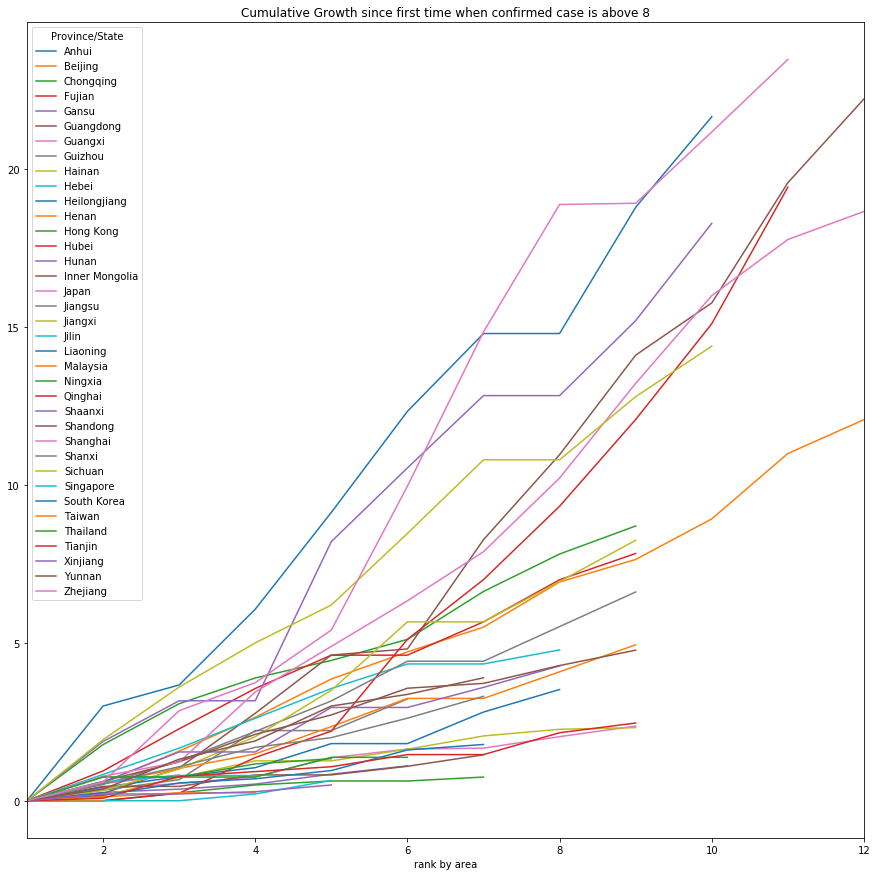

In [22]:
heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'rank by area', values='cumulative growth')
cmlt_growth_df.plot.line(figsize =(15, 15), 
                                         title ='Cumulative Growth since first time when confirmed case is above 8')
                                         #ylim =(0, 2)#)

In [23]:
cmlt_growth_df.max().sort_values().index

Index(['Malaysia', 'Qinghai', 'Taiwan', 'South Korea', 'Xinjiang', 'Jilin',
       'Hong Kong', 'Singapore', 'Japan', 'Gansu', 'Ningxia', 'Thailand',
       'Inner Mongolia', 'Liaoning', 'Hainan', 'Guangxi', 'Tianjin', 'Guizhou',
       'Shanxi', 'Heilongjiang', 'Yunnan', 'Shaanxi', 'Shandong', 'Hebei',
       'Henan', 'Jiangsu', 'Fujian', 'Jiangxi', 'Chongqing', 'Beijing',
       'Sichuan', 'Hunan', 'Shanghai', 'Hubei', 'Anhui', 'Guangdong',
       'Zhejiang'],
      dtype='object', name='Province/State')

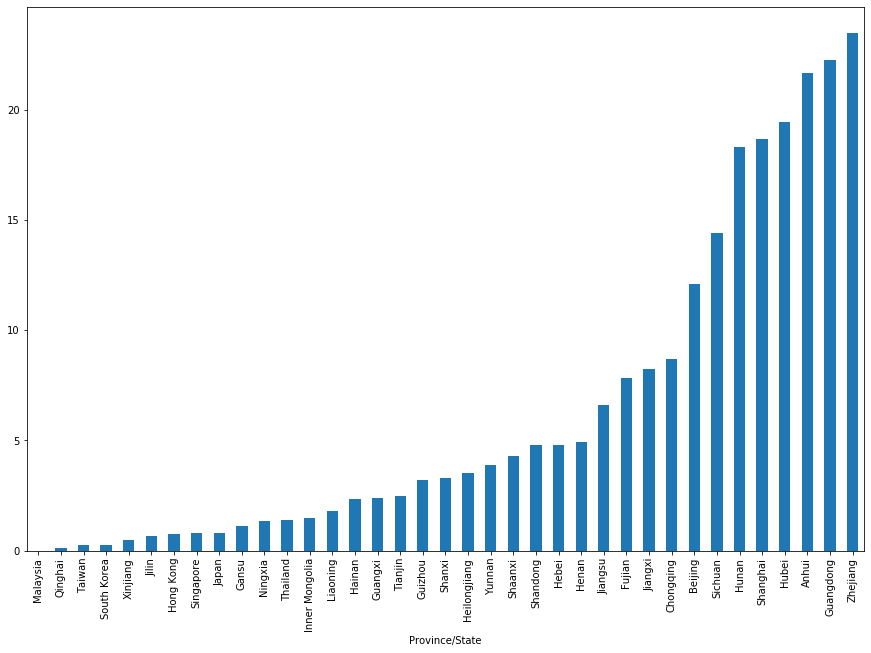

In [24]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(15,10))

In [25]:
# the following provinces/states have the highest cumulative growth
cmlt_growth_df[['Beijing', 'Sichuan','Hunan', 'Shanghai', 'Hubei', 'Anhui', 'Guangdong', 'Zhejiang','Hong Kong']]

Province/State,Beijing,Sichuan,Hunan,Shanghai,Hubei,Anhui,Guangdong,Zhejiang,Hong Kong
rank by area,,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
2.0,0.571429,1.933333,1.875000,0.777778,0.000000,3.000000,0.230769,0.592593,0.000
3.0,1.571429,3.600000,3.166667,1.222222,0.236486,3.666667,1.038462,2.851852,0.250
4.0,2.642857,5.000000,3.166667,3.444444,1.369369,6.066667,2.769231,3.740741,0.500
5.0,3.857143,6.200000,8.208333,4.888889,2.204955,9.133333,4.615385,5.407407,0.625
6.0,4.714286,8.466667,10.541667,6.333333,5.112613,12.333333,4.807692,9.962963,0.625
7.0,5.500000,10.800000,12.833333,7.888889,7.004505,14.800000,8.269231,14.851852,0.750
8.0,6.928571,10.800000,12.833333,10.222222,9.328829,14.800000,10.961538,18.888889,NaN
9.0,7.642857,12.800000,15.208333,13.222222,12.076577,18.800000,14.115385,18.925926,NaN


In [26]:
clean_df[clean_df['Province/State'] =='Hong Kong']

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
205,Hong Kong,1,21,2020-01-21 00:00:00,0.0,117.0,0.0,0.0,2020-01-21,NaN,NaN,NaN
206,Hong Kong,1,22,2020-01-22 12:00:00,0.0,117.0,0.0,0.0,2020-01-22,0.0,0.0,NaN
207,Hong Kong,1,23,2020-01-23 12:00:00,2.0,65.0,0.0,0.0,2020-01-23,0.0,2.0,inf
208,Hong Kong,1,24,2020-01-24 12:00:00,2.0,36.0,0.0,0.0,2020-01-24,2.0,0.0,0.000000
209,Hong Kong,1,25,2020-01-25 12:00:00,5.0,244.0,0.0,0.0,2020-01-25,2.0,3.0,1.500000
210,Hong Kong,1,26,2020-01-26 23:00:00,8.0,244.0,0.0,0.0,2020-01-26,5.0,3.0,0.600000
211,Hong Kong,1,27,2020-01-27 20:30:00,8.0,0.0,0.0,0.0,2020-01-27,8.0,0.0,0.000000
212,Hong Kong,1,28,2020-01-28 23:00:00,8.0,0.0,0.0,0.0,2020-01-28,8.0,0.0,0.000000
213,Hong Kong,1,29,2020-01-29 21:00:00,10.0,0.0,0.0,0.0,2020-01-29,8.0,2.0,0.250000
214,Hong Kong,1,30,2020-01-30 21:30:00,12.0,0.0,0.0,0.0,2020-01-30,10.0,2.0,0.200000


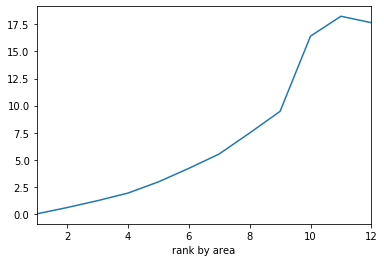

In [48]:
# deceleration? (caveat: ommited variable)
cmlt_growth_df.mean(axis=1).plot()

##### Recover rate using the latest data available

In [27]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()
latest_df

,Province/State,Last Update
0,Anhui,2020-02-02 01:33:00
1,Arizona,2020-02-01 10:00:00
2,Australia,2020-01-27 09:00:00
3,Bavaria,2020-02-01 10:00:00
4,Beijing,2020-02-02 03:05:00
...,...,...
73,Vietnam,2020-02-01 10:00:00
74,Washington,2020-02-01 10:00:00
75,Xinjiang,2020-02-02 00:43:00
76,Yunnan,2020-02-01 15:53:00


In [28]:
latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Anhui,2,2,2020-02-02 01:33:00,340.0,0.0,5.0,0.0,2020-02-02,297.0,43.0,0.144781,0.014706
1,Arizona,2,1,2020-02-01 10:00:00,1.0,0.0,0.0,0.0,2020-02-01,1.0,0.0,0.000000,0.000000
2,Australia,1,27,2020-01-27 09:00:00,5.0,0.0,0.0,0.0,2020-01-27,4.0,1.0,0.250000,0.000000
3,Bavaria,2,1,2020-02-01 10:00:00,7.0,0.0,0.0,0.0,2020-02-01,7.0,0.0,0.000000,0.000000
4,Beijing,2,2,2020-02-02 03:05:00,183.0,0.0,9.0,1.0,2020-02-02,168.0,15.0,0.089286,0.049180
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Vietnam,2,1,2020-02-01 10:00:00,6.0,0.0,1.0,0.0,2020-02-01,2.0,4.0,2.000000,0.166667
74,Washington,2,1,2020-02-01 10:00:00,1.0,0.0,0.0,0.0,2020-02-01,1.0,0.0,0.000000,0.000000
75,Xinjiang,2,2,2020-02-02 00:43:00,21.0,0.0,0.0,0.0,2020-02-02,18.0,3.0,0.166667,0.000000
76,Yunnan,2,1,2020-02-01 15:53:00,93.0,0.0,2.0,0.0,2020-02-01,83.0,10.0,0.120482,0.021505


Percentage over total confirmed cases: 2.35%


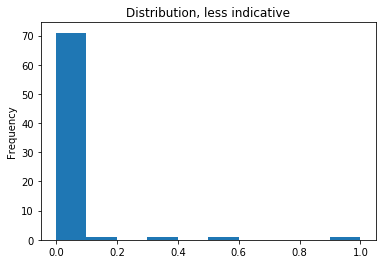

In [29]:
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Percentage over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

#### Alternative method choose worksheet before merging

In [30]:
xl = pd.ExcelFile(file_path)
xl.sheet_names

['Feb01_11pm',
 'Feb01_6pm',
 'Feb01_10am',
 'Jan31_7pm',
 'Jan31_2pm',
 'Jan30_930pm',
 'Jan30_11am',
 'Jan29_9pm',
 'Jan29_230pm',
 'Jan29_130pm',
 'Jan28_11pm',
 'Jan28_6pm',
 'Jan28_1pm',
 'Jan27_830pm',
 'Jan27_7pm',
 'Jan27_9am',
 'Jan26_11pm',
 'Jan26_11am',
 'Jan25_10pm',
 'Jan25_12pm',
 'Jan25_12am',
 'Jan24_12pm',
 'Jan24_12am',
 'Jan23_12pm',
 'Jan22_12pm',
 'Jan22_12am']

In [31]:
# use the latest time for each date
split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
split_name_df

,date,hour
0,Feb01,11pm
1,Feb01,6pm
2,Feb01,10am
3,Jan31,7pm
4,Jan31,2pm
5,Jan30,930pm
6,Jan30,11am
7,Jan29,9pm
8,Jan29,230pm
9,Jan29,130pm


In [32]:
# extract time components
split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

In [33]:
# deal with special case of 12am and half-hour

split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

In [34]:
# filter for the last file for each day

filter_name_df = split_name_df[split_name_df.suffix == 'pm']

filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

filter_name_df

,date_digit,hour_digit,suffix
0,1,11,pm
1,21,24,pm
2,22,12,pm
3,23,24,pm
4,24,24,pm
5,25,12,pm
6,26,11,pm
7,27,8,pm
8,28,11,pm
9,29,9,pm


In [35]:
filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
         left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
filter_name

['Feb01_11pm',
 'Jan31_7pm',
 'Jan30_930pm',
 'Jan29_9pm',
 'Jan28_11pm',
 'Jan27_830pm',
 'Jan26_11pm',
 'Jan25_12pm',
 'Jan25_12am',
 'Jan24_12am',
 'Jan22_12pm',
 'Jan22_12am']

In [36]:
main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [37]:
main_2_df['Last Update'].value_counts()

2020-01-31 19:00:00    63
2020-01-30 21:30:00    59
2020-01-29 21:00:00    56
2020-01-27 20:30:00    52
2020-01-28 23:00:00    51
2020-01-26 23:00:00    47
2020-01-25 00:00:00    44
2020-01-25 12:00:00    44
2020-01-24 00:00:00    38
2020-01-22 12:00:00    38
2020-01-31 08:15:00     9
2020-02-02 01:03:00     6
2020-02-01 18:12:00     6
2020-02-01 19:43:00     4
2020-02-01 19:53:00     3
2020-02-01 23:33:00     3
2020-02-01 01:52:00     3
2020-02-02 03:23:00     2
2020-02-02 01:23:00     2
2020-02-01 23:43:00     2
2020-02-02 03:43:00     2
2020-02-02 00:23:00     2
2020-02-02 00:43:00     1
2020-02-02 01:13:00     1
2020-02-01 07:38:00     1
2020-02-01 15:43:00     1
2020-02-01 05:37:00     1
2020-02-01 15:23:00     1
2020-02-02 03:33:00     1
2020-01-31 15:20:00     1
2020-02-02 01:33:00     1
2020-01-28 18:00:00     1
2020-02-01 15:53:00     1
2020-01-31 10:37:00     1
2020-02-02 01:53:00     1
2020-02-02 02:03:00     1
2020-02-02 00:53:00     1
2020-02-01 18:53:00     1
2020-02-02 0

In [38]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)